In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Data Loading and Analysis

In [10]:
df = pd.read_csv('data/wine_quality.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,top_quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


In [11]:
df.top_quality.unique()

array([0, 1], dtype=int64)

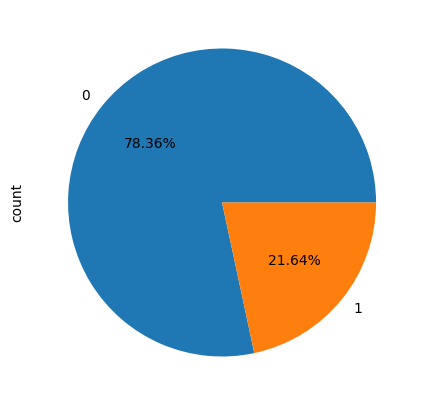

In [12]:
#podaci su lose balansirani
plt.figure(figsize=(8,5))
df['top_quality'].value_counts().plot.pie(autopct='%.2f%%')
plt.show()


All attributes are numeric, but on different scales, so we need to normalize them. Additionally, we have imbalanced data with a 4:1 ratio for the target class, so it would be good to balance the data.

# Model Creation

### Outlier Removal

In [13]:
from scipy import stats

df_no_out = df.loc[(np.abs(stats.zscore(df)) < 3).all(axis=1), :]

In [14]:
print(f'{str(df.shape[0] - df_no_out.shape[0])} Outliers have been removed. Percentage: {str((df.shape[0] - df_no_out.shape[0]) / df.shape[0])}')

396 Outliers have been removed. Percentage: 0.08084932625561454


### Splitting into Training and Test Data

In [15]:
X = df_no_out.drop('top_quality', axis=1)
# In the training set, all data except for the 'top quality' column are included, as it is needed for the classification output.
y = df_no_out['top_quality'] # test skup

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 
# For data balancing, stratify.

In [17]:
print(f'Training size: {str(X_train.shape[0])}. Test size: {str(X_test.shape[0])}')

Training size: 3151. Test size: 1351


### Data Scaling

MaxMinScaler was used, which was "learned" on the training set and then only used to transform the test set.

In [18]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[0.79591837, 0.38      , 0.49275362, ..., 0.45882353, 0.47540984,
        0.32758621],
       [0.28571429, 0.46      , 0.47826087, ..., 0.45882353, 0.62295082,
        0.36206897],
       [0.79591837, 0.14      , 0.56521739, ..., 0.34117647, 0.27868852,
        0.36206897],
       ...,
       [0.51020408, 0.34      , 0.42028986, ..., 0.25882353, 0.2295082 ,
        0.56896552],
       [0.42857143, 0.6       , 0.49275362, ..., 0.41176471, 0.8852459 ,
        0.27586207],
       [0.32653061, 0.2       , 0.44927536, ..., 0.64705882, 0.59016393,
        0.46551724]])

## Initial Models

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

### KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

model_rff = RandomForestClassifier()
model_rff.fit(X_train, y_train)

RandomForestClassifier()

### Evaluation

- Assess the generalization error for all models based on several metrics

In [25]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from prettytable import PrettyTable

In [44]:
def evaluate(models, scores, X=X_train, y=y_train):
    t = PrettyTable(['Model\Evaluation Metric'] + [str(score).split()[1] for score in scores])
    for model in models:
        y_pred = model.predict(X)
        t.add_row([str(model).split('(')[0]] + [score(y, y_pred) for score in scores])
    print(t)
    print('\n')

In [45]:
models = [model_lr, model_tree, model_knn, model_rff]
scores = [accuracy_score, precision_score, recall_score, roc_auc_score]

evaluate(models, scores, X_train, y_train) #evaluacija podataka za trening 

+-------------------------+--------------------+--------------------+---------------------+--------------------+
| Model\Evaluation Metric |   accuracy_score   |  precision_score   |     recall_score    |   roc_auc_score    |
+-------------------------+--------------------+--------------------+---------------------+--------------------+
|    LogisticRegression   | 0.7997461123452873 |      0.63125       | 0.28251748251748254 | 0.6170387084180188 |
|  DecisionTreeClassifier |        1.0         |        1.0         |         1.0         |        1.0         |
|   KNeighborsClassifier  | 0.8803554427165979 | 0.7835570469798657 |  0.6531468531468532 | 0.8000955940611113 |
|  RandomForestClassifier |        1.0         |        1.0         |         1.0         |        1.0         |
+-------------------------+--------------------+--------------------+---------------------+--------------------+




In [46]:
evaluate(models, scores, X_test, y_test) #evaluacija podataka za test

+-------------------------+--------------------+--------------------+---------------------+--------------------+
| Model\Evaluation Metric |   accuracy_score   |  precision_score   |     recall_score    |   roc_auc_score    |
+-------------------------+--------------------+--------------------+---------------------+--------------------+
|    LogisticRegression   | 0.7927461139896373 | 0.6140350877192983 | 0.22875816993464052 | 0.593326453388373  |
|  DecisionTreeClassifier | 0.8179126572908957 | 0.6027397260273972 |  0.5751633986928104 | 0.7320793070019076 |
|   KNeighborsClassifier  | 0.8164322723908216 | 0.6141732283464567 |  0.5098039215686274 | 0.7080120086312037 |
|  RandomForestClassifier | 0.8712065136935603 | 0.7796610169491526 |  0.6013071895424836 | 0.7757732119961223 |
+-------------------------+--------------------+--------------------+---------------------+--------------------+




### Evaluacija unakrsnom cross-validacijom

    - prikazati i standardnu devijaciju procene greške (od 10 kros-validacionih uzoraka)

In [47]:
from sklearn.model_selection import cross_val_score

for model, label in zip([model_lr, model_tree, model_knn, model_rff], ['Logistic regression', 'Descision Tree', 'K-NN', 'Random Forest']):
    cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    print('[%s] Accuracy: %0.2f +/- %0.2f' % (label, cv_scores.mean(), cv_scores.std()))

[Logistic regression] Accuracy: 0.78 +/- 0.03
[Descision Tree] Accuracy: 0.75 +/- 0.03
[K-NN] Accuracy: 0.74 +/- 0.03
[Random Forest] Accuracy: 0.80 +/- 0.01


The models are overfitting as there is a variation of 2-4% in accuracy. In particular, the DT model is overfitting, which is expected because it is not constrained by any meta-parameters. Additionally, from the standard training-test evaluation, it is clear that the KNN and RF models are also overfitting, as there are significant differences in accuracy between these two sets.

For this problem, the most appropriate metric is Recall. Our positive class is that the wine is of good quality. If we consider the problem as wanting to detect all wines that are good, then our error of not detecting some good wine (FN) is much more costly than mistakenly classifying a bad wine as good (FP). If we miss a good wine, it remains undiscovered, while if we classify a bad wine as good, in the worst case, we will taste it and conclude that it is actually bad. Therefore, an adequate evaluation measure is one that emphasizes the significance of FN errors - that is Recall.

Recall= TP/(TP+FN)


### Modifying the Decision Threshold

- Modify the decision threshold so that the model makes more inexpensive errors

In [48]:
def evaluate_with_treshold(models, scores, threshold, X, y):
    t = PrettyTable(['Model\Evaluation Metric'] + [str(score).split()[1] for score in scores])
    for model in models:
        y_pred = (model.predict_proba(X)[:,1] >= threshold).astype(bool)
        t.add_row([str(model).split('(')[0]] + [score(y, y_pred) for score in scores])
    print(t)
    print('\n')

In [49]:
evaluate_with_treshold(models, scores, 0.3, X_train, y_train)

+-------------------------+--------------------+--------------------+--------------------+--------------------+
| Model\Evaluation Metric |   accuracy_score   |  precision_score   |    recall_score    |   roc_auc_score    |
+-------------------------+--------------------+--------------------+--------------------+--------------------+
|    LogisticRegression   | 0.7654712789590606 | 0.4866369710467706 | 0.6111888111888112 | 0.7109720739031083 |
|  DecisionTreeClassifier |        1.0         |        1.0         |        1.0         |        1.0         |
|   KNeighborsClassifier  | 0.8562361155188829 | 0.6347736625514403 | 0.862937062937063  | 0.8586031784307646 |
|  RandomForestClassifier | 0.9974611234528721 | 0.9889349930843707 |        1.0         | 0.9983579638752053 |
+-------------------------+--------------------+--------------------+--------------------+--------------------+




We will display the results of the initial models and the models with the shifted decision threshold to facilitate comparison of what happened with the threshold adjustment.

In [50]:
evaluate(models, scores, X_test, y_test)

+-------------------------+--------------------+--------------------+---------------------+--------------------+
| Model\Evaluation Metric |   accuracy_score   |  precision_score   |     recall_score    |   roc_auc_score    |
+-------------------------+--------------------+--------------------+---------------------+--------------------+
|    LogisticRegression   | 0.7927461139896373 | 0.6140350877192983 | 0.22875816993464052 | 0.593326453388373  |
|  DecisionTreeClassifier | 0.8179126572908957 | 0.6027397260273972 |  0.5751633986928104 | 0.7320793070019076 |
|   KNeighborsClassifier  | 0.8164322723908216 | 0.6141732283464567 |  0.5098039215686274 | 0.7080120086312037 |
|  RandomForestClassifier | 0.8712065136935603 | 0.7796610169491526 |  0.6013071895424836 | 0.7757732119961223 |
+-------------------------+--------------------+--------------------+---------------------+--------------------+




In [51]:
evaluate_with_treshold(models, scores, 0.3, X_test, y_test)

+-------------------------+--------------------+---------------------+--------------------+--------------------+
| Model\Evaluation Metric |   accuracy_score   |   precision_score   |    recall_score    |   roc_auc_score    |
+-------------------------+--------------------+---------------------+--------------------+--------------------+
|    LogisticRegression   | 0.7572168763878608 |  0.4696132596685083 | 0.5555555555555556 | 0.6859117490696438 |
|  DecisionTreeClassifier | 0.8179126572908957 |  0.6027397260273972 | 0.5751633986928104 | 0.7320793070019076 |
|   KNeighborsClassifier  | 0.7668393782383419 | 0.48951048951048953 | 0.6862745098039216 | 0.7383525659067455 |
|  RandomForestClassifier | 0.8327165062916358 |  0.5930232558139535 | 0.8333333333333334 | 0.8329346092503987 |
+-------------------------+--------------------+---------------------+--------------------+--------------------+




We can see that by shifting the decision threshold, we sacrificed precision and accuracy to achieve better recall. Notice that, except for the DT model, all other models also increased the roc_auc score. The DT model did not change any score, which means that this model gives quite extreme probabilities, so the classes were not changed even when the threshold was shifted. For the other models, the differences are significant because the decision threshold was lowered by as much as 0.2 (by default, it is 0.5). This threshold is suitable only if it is essential for us not to miss many wines of good quality, and the FP error, which we will often make in this case, is cheap.

### Class Balancing

In [52]:
df.top_quality.value_counts(normalize=True)

top_quality
0    0.783585
1    0.216415
Name: proportion, dtype: float64

As already mentioned, the data is highly imbalanced. We have concluded that the positive class is more important, as it is five times smaller than the negative classes in the dataset. Given this, the models we build find it challenging to achieve good recall. We will try to balance the training set to see if we can get better results this way. It has been decided to apply the undersampling technique - we will reduce the number of observations of the negative class in the training set.

In [53]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=420)
X_train_b, y_train_b = under_sampler.fit_resample(X_train, y_train)

In [55]:
model_rf_b = RandomForestClassifier() #best model
model_rf_b.fit(X_train_b, y_train_b)

model_lr_b=LogisticRegression() 
model_lr_b.fit(X_train_b, y_train_b)

b_models = [model_rf_b, model_lr_b]
e_models = [model_rff, model_lr]

In [56]:
evaluate(e_models + b_models, scores, X_test, y_test)

+-------------------------+--------------------+--------------------+---------------------+--------------------+
| Model\Evaluation Metric |   accuracy_score   |  precision_score   |     recall_score    |   roc_auc_score    |
+-------------------------+--------------------+--------------------+---------------------+--------------------+
|  RandomForestClassifier | 0.8712065136935603 | 0.7796610169491526 |  0.6013071895424836 | 0.7757732119961223 |
|    LogisticRegression   | 0.7927461139896373 | 0.6140350877192983 | 0.22875816993464052 | 0.593326453388373  |
|  RandomForestClassifier | 0.7964470762398224 | 0.5316973415132924 |  0.8496732026143791 | 0.8152672233167588 |
|    LogisticRegression   | 0.7239082161361954 | 0.4344422700587084 |  0.7254901960784313 | 0.7244675860774932 |
+-------------------------+--------------------+--------------------+---------------------+--------------------+




We see that after class balancing, the Recall has significantly increased.

Best attributes

In [57]:
feature_importance = pd.DataFrame({'feature': df.columns[:-1], 
              'lr_coefs': model_lr_b.coef_[0],
              'rf_importance': model_rf_b.feature_importances_})

feature_importance.sort_values(by='rf_importance', ascending=False)

,feature,lr_coefs,rf_importance
10,alcohol,3.445121,0.163392
7,density,-1.873756,0.116093
1,volatile acidity,-1.652666,0.094717
4,chlorides,-1.320235,0.089186
8,pH,1.557418,0.089122
6,total sulfur dioxide,-0.583349,0.086580
5,free sulfur dioxide,0.842108,0.081456
3,residual sugar,1.586256,0.075840
2,citric acid,0.067800,0.074106
0,fixed acidity,0.997347,0.064943


The LR model struggles significantly with imbalanced data, so we are better off trusting the imbalanced RF model. Therefore, even after balancing, RF yields better results and there is less difference between the results when working with balanced and imbalanced data. Hence, we choose RF as our model. On the other hand, we can notice that the coefficients of logistic regression are more useful in explaining the model because we can see precisely whether an attribute positively or negatively affects the target class.